In [1]:
import networkx as nx
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

def find_subgraph(G: nx.Graph, subs: list[nx.Graph]):
    """
    Check each H in subs to see if H is (node-)subgraph-isomorphic to G.
    Returns (H, mapping) for the first match, else (None, None).
    The returned mapping is H-node → G-node.
    """
    for H in subs:
        # Quick size filter
        if H.number_of_nodes() > G.number_of_nodes() or H.number_of_edges() > G.number_of_edges():
            continue

        gm = isomorphism.GraphMatcher(G, H)
        if gm.subgraph_is_isomorphic():
            # mapping_g2h: G‑node → H‑node
            mapping_g2h = next(gm.subgraph_isomorphisms_iter())
            # invert to get H‑node → G‑node
            mapping_h2g = {h: g for g, h in mapping_g2h.items()}
            return H, mapping_h2g

    return None, None

def display_graph(G: nx.Graph, title: str = "", highlight: dict = None):
    """
    Draws G. If highlight is provided as {'nodes': [...], 'edges': [...]},
    those are drawn in red on top of the base graph.
    """
    pos = nx.spring_layout(G)
    nx.draw(G, pos,
            with_labels=True,
            node_color="lightblue",
            node_size=500,
            edge_color="gray",
            linewidths=1)

    if highlight:
        nx.draw_networkx_nodes(G, pos,
                               nodelist=highlight.get('nodes', []),
                               node_color="red",
                               node_size=600)
        nx.draw_networkx_edges(G, pos,
                               edgelist=highlight.get('edges', []),
                               edge_color="red",
                               width=2)

    plt.title(title)
    plt.axis('off')
    plt.show()


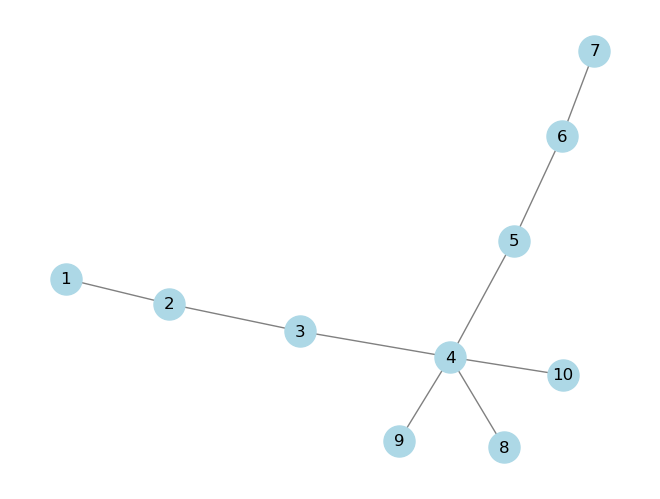

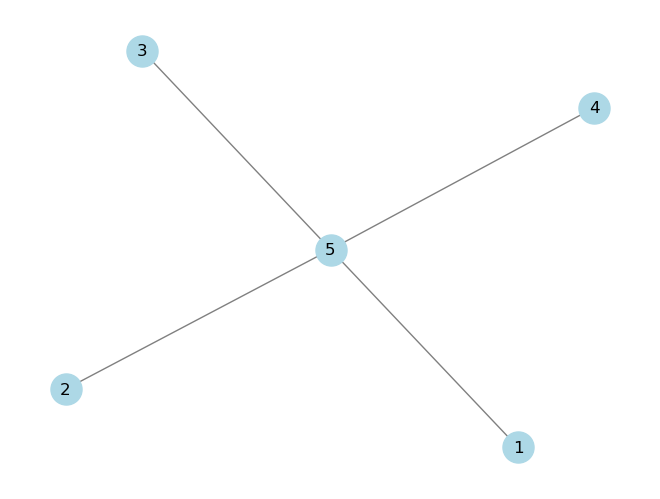

Found subgraph with edges: [(1, 5), (5, 2), (5, 3), (5, 4)]
Node mapping (subgraph → G): {1: 3, 5: 4, 2: 5, 3: 8, 4: 9}


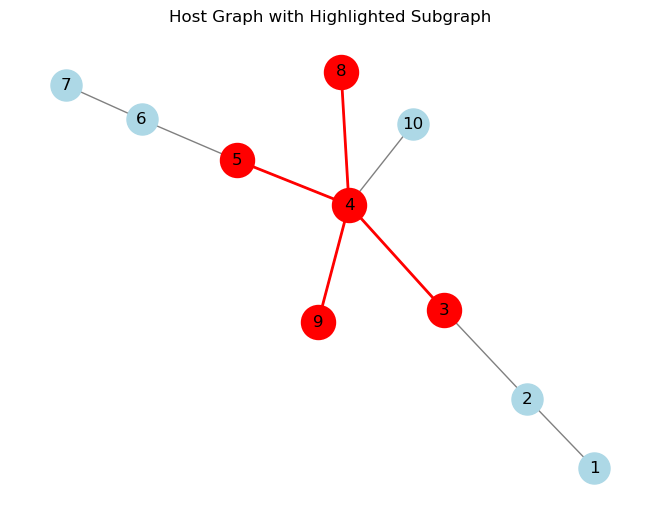

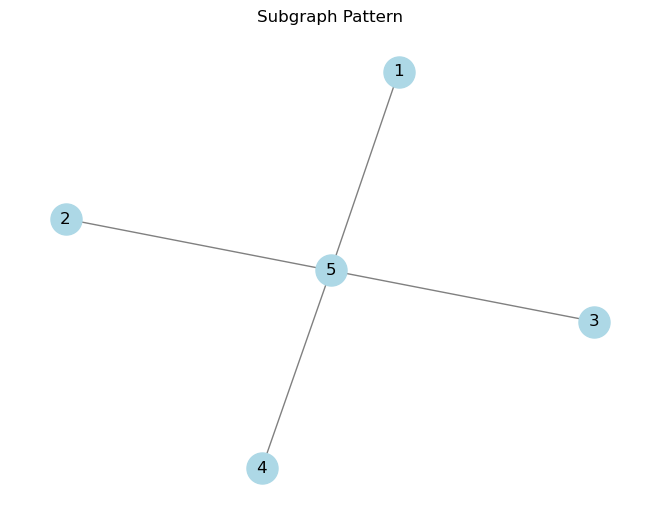

In [6]:

# --- build your main graph G ---
quiver = nx.Graph()
quiver.add_edges_from([
    (1,2), (2,3), (3,4), (4,5), (5,6), (6,7),
    (4,8), (4,9), (4,10)
])

# --- build candidate subgraphs ---
d4_quiver = nx.Graph()
d4_quiver.add_edges_from([
    (1,5), (2,5), (3,5), (4,5)
])

display_graph(quiver)
display_graph(d4_quiver)

found, mapping = find_subgraph(quiver, [d4_quiver])

if found:
    print("Found subgraph with edges:", list(found.edges()))
    print("Node mapping (subgraph → G):", mapping)

    # build highlights in G
    mapped_nodes = list(mapping.values())
    mapped_edges = [(mapping[u], mapping[v]) for u, v in found.edges()]

    # display
    display_graph(quiver,
                  title="Host Graph with Highlighted Subgraph",
                  highlight={'nodes': mapped_nodes,
                             'edges': mapped_edges})
    display_graph(found, title="Subgraph Pattern")
else:
    print("No subgraph found.")
    display_graph(quiver, title="Host Graph (no match found)")

# H1 = nx.cycle_graph(4)      # a 4-cycle
# H2 = nx.path_graph(3)       # a path of length 2
# subs = [H1, H2]

# # --- find first match ---
# found, mapping = find_subgraph(G, subs)

# if found:
    # print("Found subgraph with edges:", list(found.edges()))
    # print("Node mapping (subgraph → G):", mapping)

    # # build highlights in G
    # mapped_nodes = list(mapping.values())
    # mapped_edges = [(mapping[u], mapping[v]) for u, v in found.edges()]

    # # display
    # display_graph(G,
                    # title="Host Graph with Highlighted Subgraph",
                    # highlight={'nodes': mapped_nodes,
                                # 'edges': mapped_edges})
    # display_graph(found, title="Subgraph Pattern")
# else:
    # print("No subgraph found.")
    # display_graph(G, title="Host Graph (no match found)")


In [13]:
import networkx as nx
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

def find_subgraph_multigraph(G: nx.MultiGraph, subs: list[nx.MultiGraph]):
    """
    Check each H in subs to see if H is subgraph-isomorphic to G (counting parallel edges).
    Returns (H, mapping_H_to_G) for the first match, else (None, None).
    """
    for H in subs:
        # quick size filter
        if H.number_of_nodes() > G.number_of_nodes() or H.number_of_edges() > G.number_of_edges():
            continue

        gm = isomorphism.MultiGraphMatcher(G, H)
        if gm.subgraph_is_isomorphic():
            # mapping_G_to_H: host‑node → pattern‑node
            mapping_g2h = next(gm.subgraph_isomorphisms_iter())
            # invert: pattern‑node → host‑node
            mapping_h2g = {h: g for g, h in mapping_g2h.items()}
            return H, mapping_h2g

    return None, None

def display_graph(G, title: str = "", highlight: dict = None):
    """
    Draws G (Graph or MultiGraph). If `highlight` is given as
        {'nodes':[...], 'edges':[ (u,v), ... ]}
    those nodes/edges are overlaid in red.
    """
    pos = nx.spring_layout(G)  # fixed layout across multiedges
    nx.draw_networkx_nodes(G, pos,
                           node_size=400,
                           node_color="lightblue")
    nx.draw_networkx_labels(G, pos)
    # draw all edges (multiedges will be slightly offset automatically)
    nx.draw_networkx_edges(G, pos,
                           edgelist=G.edges(),
                           edge_color="gray")
    if highlight:
        nx.draw_networkx_nodes(G, pos,
                               nodelist=highlight.get('nodes', []),
                               node_color="red",
                               node_size=500)
        # highlight each matching edge pair (may repeat for multiedges)
        nx.draw_networkx_edges(G, pos,
                               edgelist=highlight.get('edges', []),
                               edge_color="red",
                               width=2)

    plt.title(title)
    plt.axis('off')
    plt.show()

def display_multigraph(G, title: str = "", highlight: dict = None):
    """
    Draws a MultiGraph G so that parallel edges appear as separate curves.
    highlight can be {'nodes': [...], 'edges': [(u,v), ...]} to overlay in red.
    """
    pos = nx.spring_layout(G)

    # draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=400)
    nx.draw_networkx_labels(G, pos)

    # draw each parallel edge with a different curvature
    # group edges by (u,v) ignoring order
    seen = {}
    for u, v, key in G.edges(keys=True):
        # determine how many times we've already drawn an edge between u,v
        pair = tuple(sorted((u, v)))
        i = seen.get(pair, 0)
        seen[pair] = i + 1

        # radial offset: spread them +/- around a small radius
        # if there are N parallel edges between u and v, i goes 0..N-1
        N = G.number_of_edges(u, v)
        # center them about zero
        rad = (i - (N-1)/2) * 0.2

        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            connectionstyle=f"arc3,rad={rad}",
            edge_color="gray"
        )

    # overlay any highlights in red
    if highlight:
        if 'nodes' in highlight:
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=highlight['nodes'],
                node_color="red",
                node_size=500
            )
        if 'edges' in highlight:
            # for highlights we can just draw them straight or with same offset logic
            nx.draw_networkx_edges(
                G, pos,
                edgelist=highlight['edges'],
                edge_color="red",
                width=2
            )

    plt.title(title)
    plt.axis('off')
    plt.show()

def find_all_subgraphs(G: nx.Graph, subs: list[nx.Graph], max_matches=None):
    """
    For each pattern H in subs, find *all* subgraph‐isomorphic embeddings into G.
    Returns a dict: H → list of mappings (H‑node → G‑node).
    If max_matches is set, stops after that many total embeddings across all patterns.
    """
    results = {}
    total = 0

    for H in subs:
        # size filter
        if H.number_of_nodes() > G.number_of_nodes() or H.number_of_edges() > G.number_of_edges():
            continue

        gm = isomorphism.GraphMatcher(G, H)
        mappings = []

        for mapping_g2h in gm.subgraph_isomorphisms_iter():
            # invert G→H into H→G
            mapping_h2g = {h: g for g, h in mapping_g2h.items()}
            # optional dedup: skip if same set of target nodes already seen
            node_set = frozenset(mapping_h2g.values())
            if all(node_set != frozenset(m.values()) for m in mappings):
                mappings.append(mapping_h2g)
                total += 1
                if max_matches and total >= max_matches:
                    break
        if mappings:
            results[H] = mappings
        if max_matches and total >= max_matches:
            break

    return results


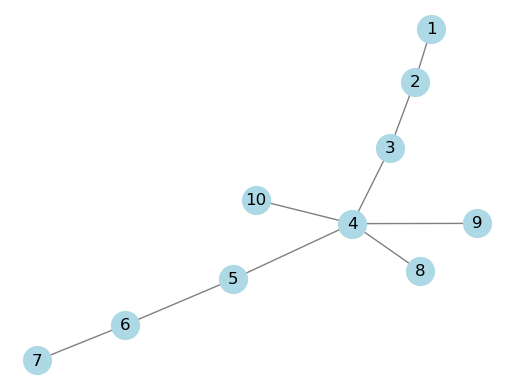

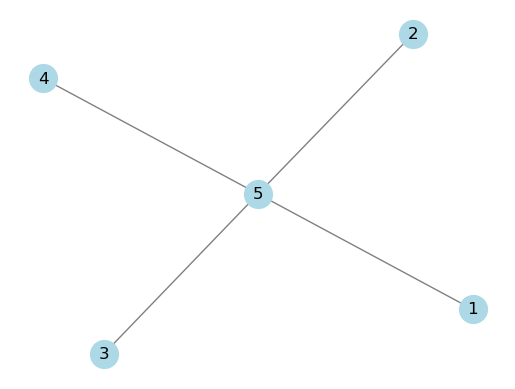

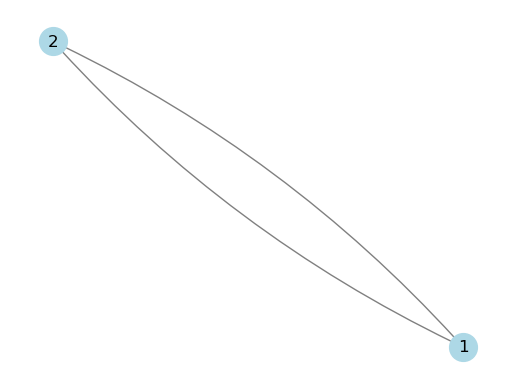

In [14]:
# --- build your main graph G ---
quiver = nx.MultiGraph()
quiver.add_edges_from([
    (1,2), (2,3), (3,4), (4,5), (5,6), (6,7),
    (4,8), (4,9), (4,10)
])

# --- build candidate subgraphs ---
d4_quiver = nx.MultiGraph()
d4_quiver.add_edges_from([
    (1,5), (2,5), (3,5), (4,5)
])

a1_quiver = nx.MultiGraph()
a1_quiver.add_edges_from([
    (1,2), (1,2)
])

display_multigraph(quiver)
display_multigraph(d4_quiver)
display_multigraph(a1_quiver)

In [15]:
matches = find_all_subgraphs(quiver, [d4_quiver, a1_quiver])

for pattern, maps in matches.items():
    print(f"Pattern edges: {pattern.edges()}")
    print(f"Found {len(maps)} distinct embeddings:")
    for i, m in enumerate(maps, 1):
        print(f"  #{i}: {m}")

Pattern edges: [(1, 5), (5, 2), (5, 3), (5, 4)]
Found 5 distinct embeddings:
  #1: {1: 3, 5: 4, 2: 5, 3: 8, 4: 9}
  #2: {1: 3, 5: 4, 2: 5, 3: 8, 4: 10}
  #3: {1: 3, 5: 4, 2: 5, 3: 9, 4: 10}
  #4: {1: 3, 5: 4, 2: 8, 3: 9, 4: 10}
  #5: {1: 5, 5: 4, 2: 8, 3: 9, 4: 10}
